<a href="https://colab.research.google.com/github/V4T5AV/ML/blob/main/ML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression & Logistic Regression assignment (Assignment 1)
This notebook implements parts (a)–(j) and an extra regression experiment.
Follow the cells in order. Explanations precede the code cells.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, fetch_california_housing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8,5)


In [2]:
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
print("X shape:", X.shape, "y shape:", y.shape)


X shape: (569, 30) y shape: (569,)


We split randomly: 80% for training+validation, 20% test.
Later cross-validation (inside training) will be used to evaluate regularization choices.
We also standardize features using StandardScaler fitted on training data only.


In [3]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler().fit(X_trainval)
X_trainval_s = scaler.transform(X_trainval)
X_test_s = scaler.transform(X_test)
print("Trainval:", X_trainval_s.shape, "Test:", X_test_s.shape)


Trainval: (455, 30) Test: (114, 30)


Objective: Given dataset {(x_i, y_i)} with y_i in {0,1}, logistic regression seeks weights w and bias b minimizing the regularized negative log-likelihood (cross-entropy):

L(w,b) = - ∑_{i=1}^N [ y_i log p_i + (1-y_i) log(1-p_i) ] + (λ/2) ||w||_2^2

where p_i = σ(w^T x_i + b) and σ(z)=1/(1+e^{-z}).
λ ≥ 0 is the L2 regularization strength. The regularizer acts only on w (not the bias).


We will:
- For each λ, train logistic regression on the **entire training+validation set** (X_trainval_s).
- Compute average cross-entropy (log loss) on trainval and test.
- Record L2 norm of the learned weight vector.
- Plot the weight values for each λ (one curve per feature).
- Plot accuracy for train and test.
We will use StratifiedKFold cross-validation to compute average training cross-entropy (fit on train folds, evaluate on the remaining fold) and then fit final model on all trainval for test evaluation.


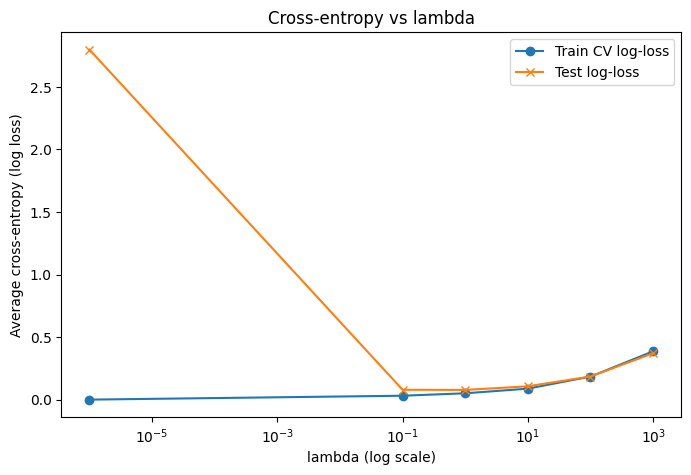

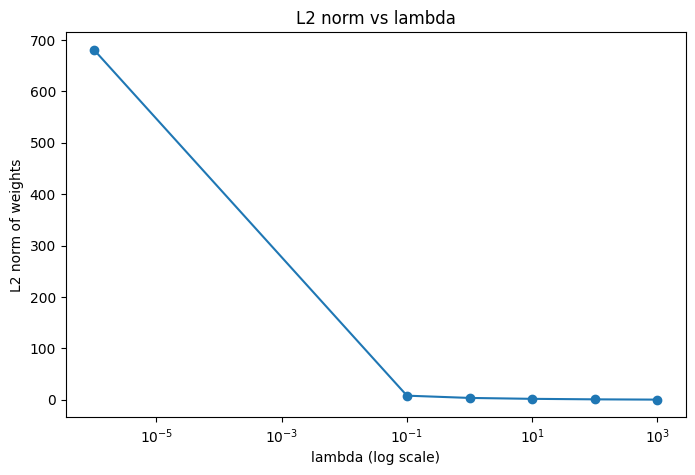

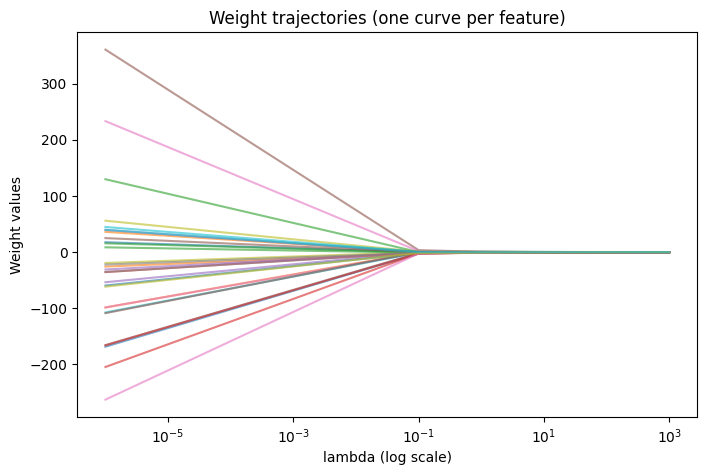

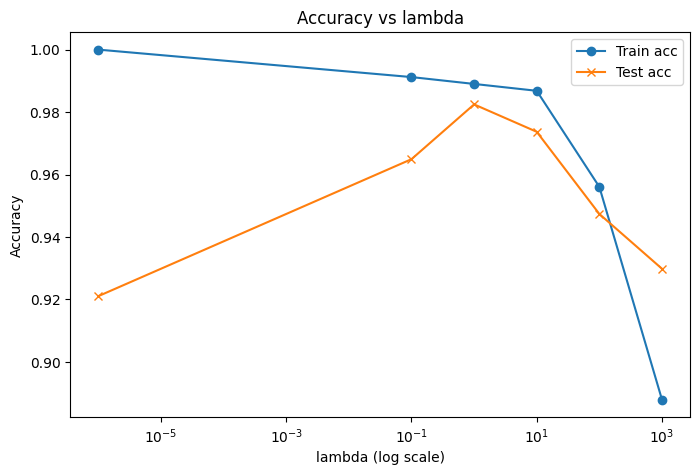

In [5]:
lambdas = [0, 0.1, 1, 10, 100, 1000]
train_losses = []
test_losses = []
weight_norms = []
weights_list = []
train_accs = []
test_accs = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for lam in lambdas:
    cv_train_losses = []
    for tr_idx, val_idx in skf.split(X_trainval_s, y_trainval):
        Xtr, Xval = X_trainval_s[tr_idx], X_trainval_s[val_idx]
        ytr, yval = y_trainval[tr_idx], y_trainval[val_idx]
        if lam == 0:
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
        else:
            C = 1.0/lam
            model = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=1000)
        model.fit(Xtr, ytr)
        probs = model.predict_proba(Xtr)[:,1]
        cv_train_losses.append(log_loss(ytr, probs))
    avg_cv_train_loss = np.mean(cv_train_losses)
    train_losses.append(avg_cv_train_loss)
    if lam == 0:
        model_final = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
    else:
        model_final = LogisticRegression(penalty='l2', C=1.0/lam, solver='lbfgs', max_iter=1000)
    model_final.fit(X_trainval_s, y_trainval)
    probs_test = model_final.predict_proba(X_test_s)[:,1]
    probs_trainval = model_final.predict_proba(X_trainval_s)[:,1]
    test_losses.append(log_loss(y_test, probs_test))
    weight = np.concatenate([model_final.coef_.ravel(), model_final.intercept_])
    weight_norms.append(np.linalg.norm(model_final.coef_))
    weights_list.append(model_final.coef_.ravel())
    train_accs.append(accuracy_score(y_trainval, (probs_trainval>=0.5).astype(int)))
    test_accs.append(accuracy_score(y_test, (probs_test>=0.5).astype(int)))

lambdas_log = [max(1e-6, l) for l in lambdas]

plt.semilogx(lambdas_log, train_losses, marker='o', label='Train CV log-loss')
plt.semilogx(lambdas_log, test_losses, marker='x', label='Test log-loss')
plt.xlabel('lambda (log scale)')
plt.ylabel('Average cross-entropy (log loss)')
plt.legend()
plt.title('Cross-entropy vs lambda')
plt.show()

plt.semilogx(lambdas_log, weight_norms, marker='o')
plt.xlabel('lambda (log scale)')
plt.ylabel('L2 norm of weights')
plt.title('L2 norm vs lambda')
plt.show()

weights_arr = np.array(weights_list)
for i in range(weights_arr.shape[1]):
    plt.semilogx(lambdas_log, weights_arr[:,i], alpha=0.6)
plt.xlabel('lambda (log scale)')
plt.ylabel('Weight values')
plt.title('Weight trajectories (one curve per feature)')
plt.show()

plt.semilogx(lambdas_log, train_accs, marker='o', label='Train acc')
plt.semilogx(lambdas_log, test_accs, marker='x', label='Test acc')
plt.xlabel('lambda (log scale)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs lambda')
plt.show()

Observations to write in your report (short):
- As λ increases, weight norms shrink (regularization effect).
- Training cross-entropy typically increases with larger λ (model is constrained), while test cross-entropy may decrease then increase (regularization reduces overfitting).
- For λ=0 (no regularization) weights may be larger and training loss smaller but risk overfitting.
- Weight trajectories show many coefficients shrink toward zero as λ grows.
- Accuracy may be stable across a range; choose λ via validation.


We will:
- Rescale each input dimension into range [-10,10] (so that means placed between -10 and 10 make sense).
- For each original input variable (except bias), create 5 univariate Gaussian basis functions with means evenly spaced between -10 and 10 and variance σ.
- Basis feature: phi_j(x) = exp( - (x - mu_j)^2 / (2*sigma^2) )
We will test sigma values [0.1, 0.5, 1, 5, 10].


In [6]:
def scale_to_range(X, a=-10, b=10):
    mm = MinMaxScaler(feature_range=(a,b))
    return mm.fit_transform(X), mm

def make_univariate_basis(X_scaled, num_basis=5, mu_min=-10, mu_max=10, sigma=1.0):
    n_samples, n_features = X_scaled.shape
    mus = np.linspace(mu_min, mu_max, num_basis)
    Phi = []
    groups = []
    for feat in range(n_features):
        col = X_scaled[:, feat]
        for mu in mus:
            phi_col = np.exp(-((col - mu)**2)/(2*(sigma**2)))
            Phi.append(phi_col.reshape(-1,1))
            groups.append((feat, sigma, mu))
    Phi = np.hstack(Phi)
    return Phi, groups

X_trainval_scaled, mm = scale_to_range(X_trainval_s, -10, 10)
X_test_scaled = mm.transform(X_test_s)


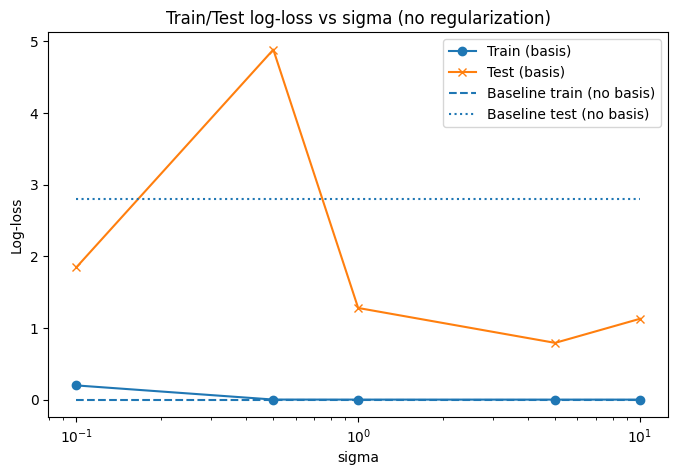

In [8]:
sigmas = [0.1, 0.5, 1, 5, 10]
train_losses_sigma = []
test_losses_sigma = []
baseline_train = train_losses[0]
baseline_test = test_losses[0]

for sigma in sigmas:
    Phi_train, groups = make_univariate_basis(X_trainval_scaled, num_basis=5, sigma=sigma)
    Phi_test, _ = make_univariate_basis(X_test_scaled, num_basis=5, sigma=sigma)
    model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
    model.fit(Phi_train, y_trainval)
    probs_train = model.predict_proba(Phi_train)[:,1]
    probs_test = model.predict_proba(Phi_test)[:,1]
    train_losses_sigma.append(log_loss(y_trainval, probs_train))
    test_losses_sigma.append(log_loss(y_test, probs_test))

plt.plot(sigmas, train_losses_sigma, marker='o', label='Train (basis)')
plt.plot(sigmas, test_losses_sigma, marker='x', label='Test (basis)')
plt.hlines(baseline_train, xmin=min(sigmas), xmax=max(sigmas), linestyles='--', label='Baseline train (no basis)')
plt.hlines(baseline_test, xmin=min(sigmas), xmax=max(sigmas), linestyles=':', label='Baseline test (no basis)')
plt.xlabel('sigma')
plt.ylabel('Log-loss')
plt.xscale('log')
plt.legend()
plt.title('Train/Test log-loss vs sigma (no regularization)')
plt.show()

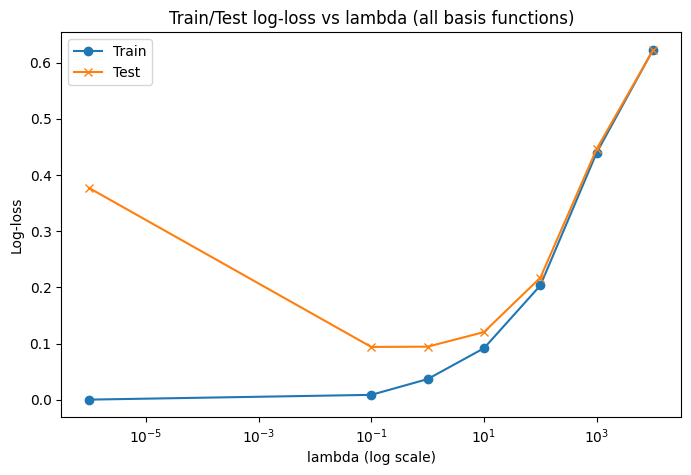

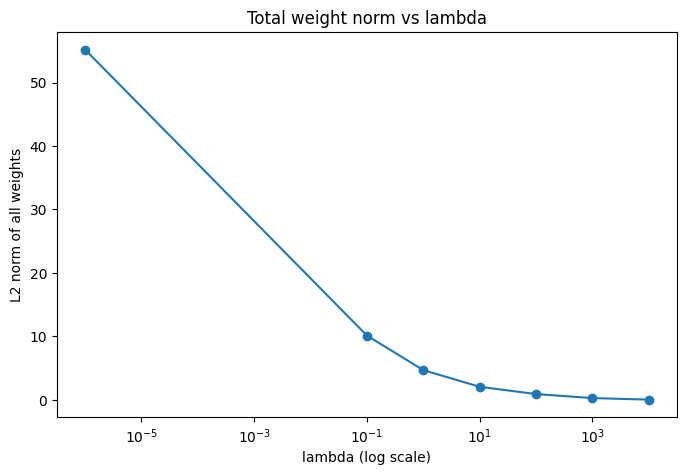

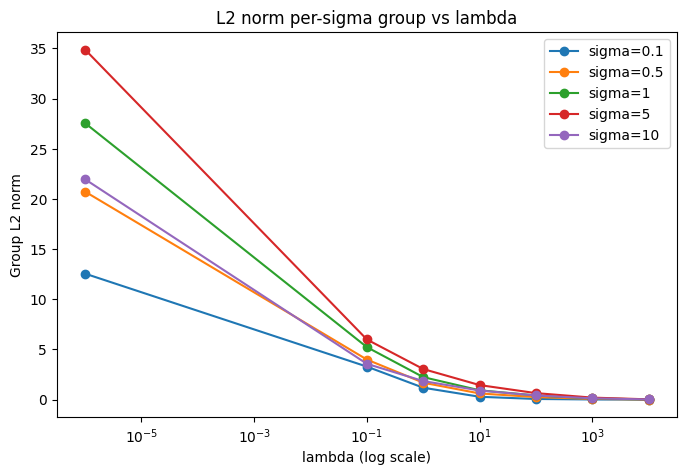

In [10]:
sigmas = [0.1, 0.5, 1, 5, 10]
Phi_train_all = []
Phi_test_all = []
group_indices = {}
start = 0
for sigma in sigmas:
    Phi_t, groups = make_univariate_basis(X_trainval_scaled, num_basis=5, sigma=sigma)
    Phi_te, _ = make_univariate_basis(X_test_scaled, num_basis=5, sigma=sigma)
    Phi_train_all.append(Phi_t)
    Phi_test_all.append(Phi_te)
    end = start + Phi_t.shape[1]
    group_indices[sigma] = (start, end)
    start = end
Phi_train_all = np.hstack(Phi_train_all)
Phi_test_all = np.hstack(Phi_test_all)

lambdas_g = [0, 0.1, 1, 10, 100, 1000, 10000]
train_losses_g = []
test_losses_g = []
weight_norms_g = []
group_norms = {sigma: [] for sigma in sigmas}

for lam in lambdas_g:
    if lam == 0:
        model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=2000)
    else:
        model = LogisticRegression(penalty='l2', C=1.0/lam, solver='lbfgs', max_iter=2000)
    model.fit(Phi_train_all, y_trainval)
    probs_tr = model.predict_proba(Phi_train_all)[:,1]
    probs_te = model.predict_proba(Phi_test_all)[:,1]
    train_losses_g.append(log_loss(y_trainval, probs_tr))
    test_losses_g.append(log_loss(y_test, probs_te))
    total_norm = np.linalg.norm(model.coef_)
    weight_norms_g.append(total_norm)
    coef = model.coef_.ravel()
    for sigma in sigmas:
        s,e = group_indices[sigma]
        gn = np.linalg.norm(coef[s:e])
        group_norms[sigma].append(gn)

plt.semilogx([max(1e-6,l) for l in lambdas_g], train_losses_g, marker='o', label='Train')
plt.semilogx([max(1e-6,l) for l in lambdas_g], test_losses_g, marker='x', label='Test')
plt.xlabel('lambda (log scale)')
plt.ylabel('Log-loss')
plt.legend()
plt.title('Train/Test log-loss vs lambda (all basis functions)')
plt.show()

plt.semilogx([max(1e-6,l) for l in lambdas_g], weight_norms_g, marker='o')
plt.xlabel('lambda (log scale)')
plt.ylabel('L2 norm of all weights')
plt.title('Total weight norm vs lambda')
plt.show()

for sigma in sigmas:
    plt.semilogx([max(1e-6,l) for l in lambdas_g], group_norms[sigma], marker='o', label=f'sigma={sigma}')
plt.xlabel('lambda (log scale)')
plt.ylabel('Group L2 norm')
plt.legend()
plt.title('L2 norm per-sigma group vs lambda')
plt.show()

In [11]:
X_one_train = X_trainval_s[:, [0]]
X_one_test = X_test_s[:, [0]]
X_one_train_scaled, mm1 = scale_to_range(X_one_train, -10, 10)
X_one_test_scaled = mm1.transform(X_one_test)

num_basis = 5
sigma = 1.0
mus = np.linspace(-10, 10, num_basis).copy()
w = np.zeros(num_basis)
b = 0.0
lam = 0.1
eta_mu = 0.01
max_iter = 40

def phi_from_mus(Xs, mus, sigma):
    cols = []
    for mu in mus:
        cols.append(np.exp(-((Xs.ravel()-mu)**2)/(2*sigma**2)).reshape(-1,1))
    return np.hstack(cols)

history = []
for it in range(max_iter):
    Phi = phi_from_mus(X_one_train_scaled, mus, sigma)
    if lam == 0:
        model = LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000)
    else:
        model = LogisticRegression(penalty='l2', C=1.0/lam, solver='lbfgs', max_iter=1000)
    model.fit(Phi, y_trainval)
    w = model.coef_.ravel().copy()
    b = model.intercept_[0]
    probs = model.predict_proba(Phi)[:,1]
    grad_mu = np.zeros_like(mus)
    for k, mu in enumerate(mus):
        phi_k = np.exp(-((X_one_train_scaled.ravel()-mu)**2)/(2*sigma**2))
        grad_mu[k] = np.sum((probs - y_trainval) * w[k] * phi_k * (X_one_train_scaled.ravel() - mu) / (sigma**2))
    mus = mus - eta_mu * grad_mu
    train_loss = log_loss(y_trainval, probs)
    history.append((it, mus.copy(), train_loss))


iter 0: loss=0.3774, mus=[-9.88857666 -5.22259869  0.10417957  4.90697608  9.99789725]
iter 5: loss=0.3309, mus=[-9.37859589 -5.70979186  0.43522316  4.52897191  9.98717082]
iter 10: loss=0.3226, mus=[-9.03345606 -5.69770277  0.52116454  4.2799655   9.97564021]
iter 15: loss=0.3176, mus=[-8.74387629 -5.56606554  0.5143111   4.11081002  9.96430097]
iter 20: loss=0.3135, mus=[-8.48784192 -5.41336874  0.48505383  3.98537569  9.95350247]
iter 25: loss=0.3102, mus=[-8.27030869 -5.2696774   0.45160201  3.88498553  9.94373983]
iter 30: loss=0.3079, mus=[-8.08901768 -5.15020379  0.42046132  3.80129871  9.93442293]
iter 35: loss=0.3066, mus=[-7.94223889 -5.05156461  0.39102466  3.72893216  9.92550086]


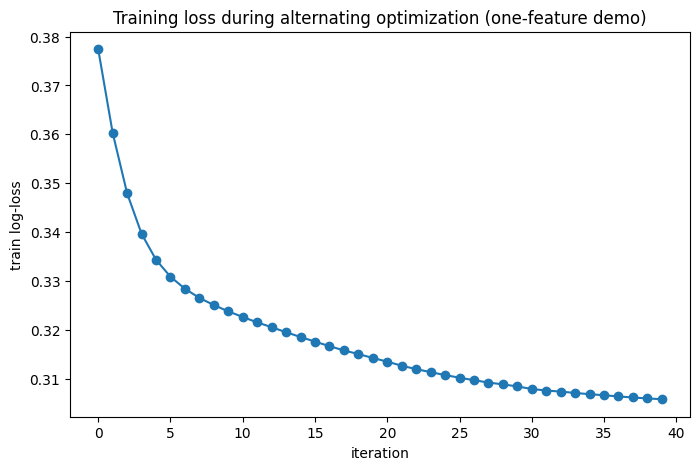

In [12]:
for it, mus_h, loss_h in history[::5]:
    print(f"iter {it}: loss={loss_h:.4f}, mus={mus_h}")
plt.plot([h[0] for h in history], [h[2] for h in history], marker='o')
plt.xlabel('iteration')
plt.ylabel('train log-loss')
plt.title('Training loss during alternating optimization (one-feature demo)')
plt.show()


In [13]:
housing = fetch_california_housing()
Xh = housing.data
yh = housing.target
Xh_train, Xh_test, yh_train, yh_test = train_test_split(Xh, yh, test_size=0.2, random_state=42)
scaler_h = StandardScaler().fit(Xh_train)
Xh_train_s = scaler_h.transform(Xh_train)
Xh_test_s = scaler_h.transform(Xh_test)


In [14]:
models = {
    "Linear": LinearRegression(),
    "Ridge (alpha=1)": Ridge(alpha=1.0),
    "Lasso (alpha=0.1)": Lasso(alpha=0.1, max_iter=5000),
    "ElasticNet (alpha=0.1, l1_ratio=0.5)": ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000)
}
results = {}
for name, m in models.items():
    m.fit(Xh_train_s, yh_train)
    preds_tr = m.predict(Xh_train_s)
    preds_te = m.predict(Xh_test_s)
    results[name] = {
        "train_mse": mean_squared_error(yh_train, preds_tr),
        "test_mse": mean_squared_error(yh_test, preds_te),
        "train_r2": r2_score(yh_train, preds_tr),
        "test_r2": r2_score(yh_test, preds_te)
    }
pd.DataFrame(results).T


,train_mse,test_mse,train_r2,test_r2
Linear,0.517933,0.555892,0.612551,0.575788
Ridge (alpha=1),0.517933,0.555855,0.612551,0.575816
Lasso (alpha=0.1),0.671840,0.679629,0.497419,0.481361
"ElasticNet (alpha=0.1, l1_ratio=0.5)",0.627268,0.635857,0.530762,0.514765


In [15]:
coef_df = pd.DataFrame({name: m.coef_ if hasattr(m, "coef_") else np.nan for name, m in models.items()})
coef_df.index = housing.feature_names
coef_df


,Linear,Ridge (alpha=1),Lasso (alpha=0.1),"ElasticNet (alpha=0.1, l1_ratio=0.5)"
MedInc,0.854383,0.854327,0.710598,0.713818
HouseAge,0.122546,0.122624,0.106453,0.137288
AveRooms,-0.294410,-0.294210,-0.000000,-0.000000
AveBedrms,0.339259,0.339008,0.000000,0.000000
Population,-0.002308,-0.002282,-0.000000,0.000000
AveOccup,-0.040829,-0.040833,-0.000000,-0.000000
Latitude,-0.896929,-0.896168,-0.011469,-0.175737
Longitude,-0.869842,-0.869071,-0.000000,-0.133250
